In [1]:
%matplotlib notebook
import numpy as np
import sigpy as sp
import matplotlib.pyplot as plt
import sigpy.plot as pl

from zte_recon.data_zte import Data_Arc_ZTE
from zte_recon.recon_gridding import recon_adjoint_postcomp_coilbycoil
from zte_recon.recon_l1_iter import recon_l1_wave_precond_coilbycoil
from zte_recon.util.sens import est_maps_3d
from zte_recon.bart_dims import coord_to_bart, ksp_to_bart
from zte_recon.arc_zte_traj import read_params_from_kacq
from zte_recon.plot import plot_coherence_pathways
from arc_zte_sim.metrics import cov_uniformity_metric

/home/shreya/cont-slew-zte/venv/lib/python3.10/site-packages/sigpy/config.py:27: UserWarning: Importing cupy.cuda.cudnn failed. For more details, see the error stack below:
libcudnn.so.8: cannot open shared object file: No such file or directory
  warnings.warn(


In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

os.environ["OMP_NUM_THREADS"] = "36"

In [3]:
seg_rot_file = '/home/shreya/cont-slew-zte/rot_txt_files/seg_golden3d_rotMats_large.txt'

# Shared acquisition parameters
dt_sampling = 8
grad_dt_sampling = 4

# Reconstruction parameters
FOV_scale = 1
FOV_scale_dir = [1,1,1]
ndrop_ROpts = 1
img_shape = [256,256,256]

# Load acquired data

In [4]:
print('Loading data')

### Scheme where theta_i's chosen to purely maximize coverage
spoke_rot_file = None
grad_segment_file = '/mikBIG/shreya/cont_slew_zte_data/20250415/Series15/kacq_arc_zte.48175'
matlab_save_dir = '/mikBIG/shreya/cont_slew_zte_eval/20250415/Series15/'

params = read_params_from_kacq(grad_segment_file)
arc_angle = params['arc_angle']
a_grad = params['a_grad']
points_per_spoke = params['points_per_spoke']
points_before_curve = params['points_before_curve']

Furthest_thetas_data = Data_Arc_ZTE(spoke_rot_file, seg_rot_file, arc_angle, points_per_spoke, 
                 points_before_curve, dt_sampling, grad_dt_sampling, a_grad, grad_segment_file,
                 matlab_save_dir, FOV_scale=FOV_scale, FOV_scale_dir=FOV_scale_dir, ndrop_ROpts=ndrop_ROpts)
Furthest_thetas_data.gradient_corr(-0.5)

################

### Scheme where theta_i's chosen randomly
spoke_rot_file = None
grad_segment_file = '/mikBIG/shreya/cont_slew_zte_data/20250415/Series16/kacq_arc_zte.51035'
matlab_save_dir = '/mikBIG/shreya/cont_slew_zte_eval/20250415/Series16/'

params = read_params_from_kacq(grad_segment_file)
arc_angle = params['arc_angle']
a_grad = params['a_grad']
points_per_spoke = params['points_per_spoke']
points_before_curve = params['points_before_curve']

Random_thetas_data = Data_Arc_ZTE(spoke_rot_file, seg_rot_file, arc_angle, points_per_spoke, 
                 points_before_curve, dt_sampling, grad_dt_sampling, a_grad, grad_segment_file,
                 matlab_save_dir, FOV_scale=FOV_scale, FOV_scale_dir=FOV_scale_dir, ndrop_ROpts=ndrop_ROpts)
Random_thetas_data.gradient_corr(-0.5)

################

### Optimization-based scheme to choose theta_i's
spoke_rot_file = None
grad_segment_file = '/mikBIG/shreya/cont_slew_zte_data/20250415/Series11/kacq_arc_zte.90839'
matlab_save_dir = '/mikBIG/shreya/cont_slew_zte_eval/20250415/Series11/'

params = read_params_from_kacq(grad_segment_file)
arc_angle = params['arc_angle']
a_grad = params['a_grad']
points_per_spoke = params['points_per_spoke']
points_before_curve = params['points_before_curve']

Optim_thetas_data = Data_Arc_ZTE(spoke_rot_file, seg_rot_file, arc_angle, points_per_spoke, 
                 points_before_curve, dt_sampling, grad_dt_sampling, a_grad, grad_segment_file,
                 matlab_save_dir, FOV_scale=FOV_scale, FOV_scale_dir=FOV_scale_dir, ndrop_ROpts=ndrop_ROpts)
Optim_thetas_data.gradient_corr(-0.5)

Loading data
Loading ksp from h5 dir: /mikBIG/shreya/cont_slew_zte_eval/20250415/Series15/
Setting nPtsPerSpoke to opxres 256
Applied gradient delay correction of -0.5
Loading ksp from h5 dir: /mikBIG/shreya/cont_slew_zte_eval/20250415/Series16/
Setting nPtsPerSpoke to opxres 256
Applied gradient delay correction of -0.5
Loading ksp from h5 dir: /mikBIG/shreya/cont_slew_zte_eval/20250415/Series11/
Setting nPtsPerSpoke to opxres 256
Applied gradient delay correction of -0.5


In [117]:
print('Estimating maps')
# Calculate espirit maps from WASPI data
maps = est_maps_3d(ksp=ksp_to_bart(Optim_thetas_data.ksp_waspi), 
                  coord=coord_to_bart(Optim_thetas_data.coord_waspi), 
                  img_shape=img_shape,
                  crop_thres=0.8, 
                  grid_size=12)
maps_arc_optim = maps.transpose(3,0,1,2) # dims back to [coils, x,y,z]

print('Estimating maps')
# Calculate espirit maps from WASPI data
maps = est_maps_3d(ksp=ksp_to_bart(Random_thetas_data.ksp_waspi), 
                  coord=coord_to_bart(Random_thetas_data.coord_waspi), 
                  img_shape=img_shape,
                  crop_thres=0.8, 
                  grid_size=12)
maps_arc_random = maps.transpose(3,0,1,2) # dims back to [coils, x,y,z]

print('Estimating maps')
# Calculate espirit maps from WASPI data
maps = est_maps_3d(ksp=ksp_to_bart(Furthest_thetas_data.ksp_waspi), 
                  coord=coord_to_bart(Furthest_thetas_data.coord_waspi), 
                  img_shape=img_shape,
                  crop_thres=0.8, 
                  grid_size=12)
maps_arc_furthest = maps.transpose(3,0,1,2) # dims back to [coils, x,y,z]

Estimating maps
Done.
Done.
Estimating maps
Done.
Done.
Estimating maps
Done.
Done.


# Coverage uniformity metrics

In [203]:
nSpk = 384

print(cov_uniformity_metric(Optim_thetas_data.coord_radial_spokes[0:nSpk, -1], n=3000))
print(cov_uniformity_metric(Random_thetas_data.coord_radial_spokes[0:nSpk, -1], n=3000))
print(cov_uniformity_metric(Furthest_thetas_data.coord_radial_spokes[0:nSpk, -1], n=3000))

1.1043594351757187
0.9686756832048515
1.1496084577225139


# Plot coherence pathways

In [22]:
def plot_coherence_pathways(DataObj, nSpokes_plot=20, spoke_start_idx=0):
    
    # Initialize array to store kstronauts to plot
    kstronauts = np.empty((nSpokes_plot, 3, DataObj.nPtsPerSpoke))
    nPoints =  DataObj.nPtsPerSpoke
    
    # Normalize coords from DataObj
    coords_normalized = DataObj.coord_radial_spokes / (2*DataObj.coord_radial_spokes.max())

    for i in range(nSpokes_plot):
        
        # Get ith spoke
        spoke = coords_normalized[i+spoke_start_idx].transpose(1,0)
        kstronauts[i] = spoke
        
        # Plot all kstronaut from ith excitation
        if (i == 0):
            c = 'b'
            label='From TR #'+str(spoke_start_idx)
        elif (i == 1):
            c = 'c'
            label='From TR #'+str(spoke_start_idx+1)
        else:
            c = 'y'
            label=None
        plt.plot(np.arange(i*nPoints, (i+1)*nPoints, 1), np.linalg.norm(spoke, axis=0), c, label=label)

        # Plot all previous coherences evolving during same TR
        for j in range(i):
            kstronauts[j] = spoke + kstronauts[j][:, -1][:, None] # update previous kstronauts
            label=None

            if (j == 0):
                c = 'b'

            elif (j == 1):
                c = 'c'

            else:
                c = 'y'
            plt.plot(np.arange(i*nPoints, (i+1)*nPoints, 1), np.linalg.norm(kstronauts[j], axis=0), c)
            

    plt.ylabel('Cycles/voxel')
#     plt.xlabel('time')
    plt.ylim([0, 4])
    plt.yticks([0, 0.5, 1, 3])
    ax = plt.gca()
    ax.set_yticklabels(['0', '0.5', '1', '3'])

    plt.tick_params(left = True, right = False , labelleft = True , 
                    labelbottom = False, bottom = False) 
    plt.legend(loc='upper left')

    plt.axhline(y=0.5, linestyle='--', c='r')
    plt.axhline(y=1, linestyle='--', c='forestgreen')


<IPython.core.display.Javascript object>


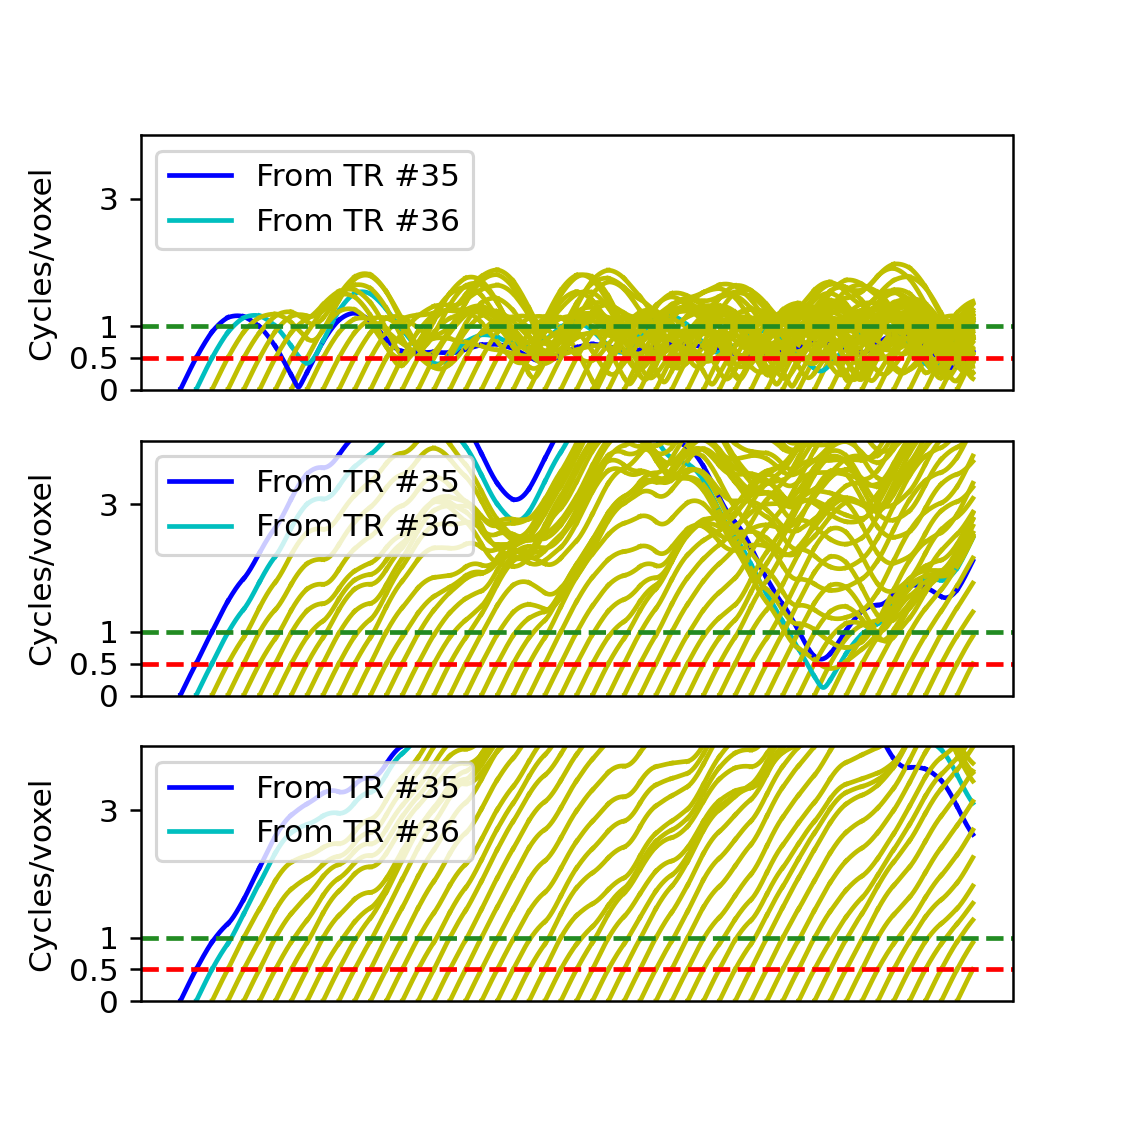

In [23]:
plt.figure(figsize=(5,5))
ax1 = plt.subplot(311)
plot_coherence_pathways(Furthest_thetas_data, nSpokes_plot=50, spoke_start_idx=35)

ax2 = plt.subplot(312)
plot_coherence_pathways(Random_thetas_data, nSpokes_plot=50, spoke_start_idx=35)

ax3 = plt.subplot(313)
plot_coherence_pathways(Optim_thetas_data, nSpokes_plot=50, spoke_start_idx=35)

In [24]:
plt.savefig('saved_figures/fig3_legend.png', dpi=800)

# Reconstruct data using gridding reconstruction

In [118]:
# Combine waspi and hires spokes
ksp_hires_waspi, coord_hires_waspi = Furthest_thetas_data.combine_waspiHires_flat()

# Gridding reconstruction
coil_ims_furthest_thetas = recon_adjoint_postcomp_coilbycoil(ksp=ksp_hires_waspi, 
                                                           coord=coord_hires_waspi, 
                                                           img_shape=img_shape, 
                                                           oversamp=1.25, norm="ortho")

# RSS coil combination
im_furthest_thetas_grid = np.sum(np.conj(maps_arc_furthest) * coil_ims_furthest_thetas, axis=0) 

##################

# Combine waspi and hires spokes
ksp_hires_waspi, coord_hires_waspi = Random_thetas_data.combine_waspiHires_flat()

# Gridding reconstruction
coil_ims_random_thetas = recon_adjoint_postcomp_coilbycoil(ksp=ksp_hires_waspi, 
                                                           coord=coord_hires_waspi, 
                                                           img_shape=img_shape, 
                                                           oversamp=1.25, norm="ortho")

# RSS coil combination
im_random_thetas_grid = np.sum(np.conj(maps_arc_random) * coil_ims_random_thetas, axis=0)

###################

# Combine waspi and hires spokes
ksp_hires_waspi, coord_hires_waspi = Optim_thetas_data.combine_waspiHires_flat()

# Gridding reconstruction
coil_ims_optim_thetas = recon_adjoint_postcomp_coilbycoil(ksp=ksp_hires_waspi, 
                                                           coord=coord_hires_waspi, 
                                                           img_shape=img_shape, 
                                                           oversamp=1.25, norm="ortho")

# RSS coil combination
im_optim_thetas_grid = np.sum(np.conj(maps_arc_optim) * coil_ims_optim_thetas, axis=0)

Coil-by-coil Gridding recon: 100%|█| 12/12 [00:20<


Coil-by-coil recon finished


Coil-by-coil Gridding recon: 100%|█| 12/12 [00:20<


Coil-by-coil recon finished


Coil-by-coil Gridding recon: 100%|█| 12/12 [00:22<


Coil-by-coil recon finished


<IPython.core.display.Javascript object>


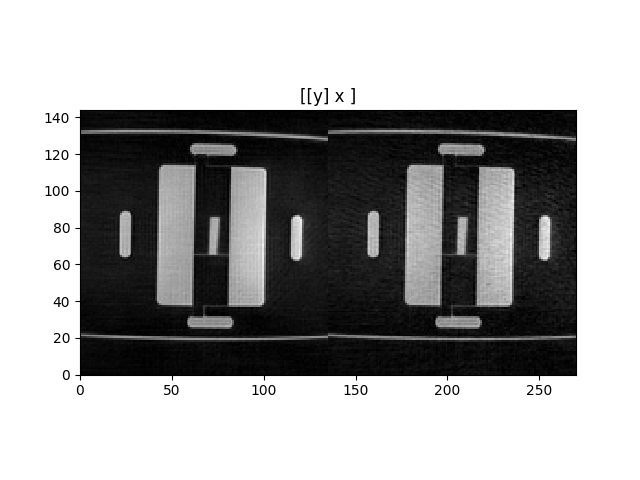

In [204]:
slice_num = 110
pl.ImagePlot(np.concatenate((im_optim_thetas_grid[56:200, slice_num, 75:210], 
                       im_random_thetas_grid[56:200, slice_num, 75:210]), axis=1))

In [172]:
plt.savefig('saved_figures/fig3_recons_gridding_sag_pt1.png', dpi=800)

<IPython.core.display.Javascript object>


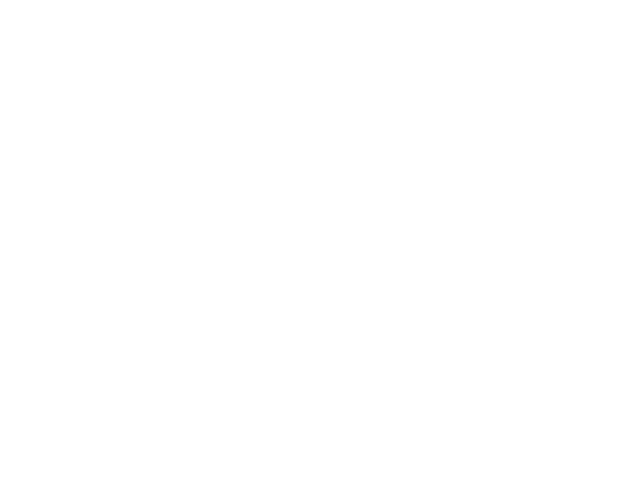

In [161]:
slice_num = 110
pl.ImagePlot(im_furthest_thetas_grid[56:200, slice_num, 75:210])

In [162]:
plt.savefig('saved_figures/fig3_recons_gridding_sag_pt2.png', dpi=500)

# l1w reg with undersampling

In [136]:
spokes_subset=np.arange(0, int(Furthest_thetas_data.nSpokes/5), 1)
scale = 2935537
lamda_wave = 0.01
nIter = 20

#########

print('Estimating maps')
# Calculate espirit maps from WASPI data
maps = est_maps_3d(ksp=ksp_to_bart(Furthest_thetas_data.ksp_waspi), 
                  coord=coord_to_bart(Furthest_thetas_data.coord_waspi), 
                  img_shape=img_shape,
                  crop_thres=0.8, 
                  grid_size=12)
maps = maps.transpose(3,0,1,2) # dims back to [coils, x,y,z]

print('Reconstructing')
# Combine waspi and hires spokes
ksp_hires_waspi, coord_hires_waspi = Furthest_thetas_data.combine_waspiHires_flat(spokes_subset=spokes_subset)


im_iter_furthest = recon_l1_wave_precond_coilbycoil(ksp_hires_waspi / scale, coord_hires_waspi,
                                                     img_shape, lamda_wave=lamda_wave, max_iter=nIter, maps=maps)

##########

print('Estimating maps')
# Calculate espirit maps from WASPI data
maps = est_maps_3d(ksp=ksp_to_bart(Random_thetas_data.ksp_waspi), 
                  coord=coord_to_bart(Random_thetas_data.coord_waspi), 
                  img_shape=img_shape,
                  crop_thres=0.8, 
                  grid_size=12)
maps = maps.transpose(3,0,1,2) # dims back to [coils, x,y,z]

print('Reconstructing')
# Combine waspi and hires spokes
ksp_hires_waspi, coord_hires_waspi = Random_thetas_data.combine_waspiHires_flat(spokes_subset=spokes_subset)


im_iter_random = recon_l1_wave_precond_coilbycoil(ksp_hires_waspi / scale, coord_hires_waspi,
                                                     img_shape, lamda_wave=lamda_wave, max_iter=nIter, maps=maps)


###########

print('Estimating maps')
# Calculate espirit maps from WASPI data
maps = est_maps_3d(ksp=ksp_to_bart(Optim_thetas_data.ksp_waspi), 
                  coord=coord_to_bart(Optim_thetas_data.coord_waspi), 
                  img_shape=img_shape,
                  crop_thres=0.8, 
                  grid_size=12)
maps = maps.transpose(3,0,1,2) # dims back to [coils, x,y,z]

print('Reconstructing')
# Combine waspi and hires spokes
ksp_hires_waspi, coord_hires_waspi = Optim_thetas_data.combine_waspiHires_flat(spokes_subset=spokes_subset)


im_iter_optim = recon_l1_wave_precond_coilbycoil(ksp_hires_waspi / scale, coord_hires_waspi,
                                                     img_shape, lamda_wave=lamda_wave, max_iter=nIter, maps=maps)

Estimating maps
Done.
Done.
Reconstructing


SystemError: CPUDispatcher(<function _get_interpolate.<locals>._interpolate3 at 0x720fe6fc3ac0>) returned a result with an exception set

In [1]:
slice_num = 125
pl.ImagePlot(np.concatenate((im_iter_optim[0][60:200, 40:170, slice_num], 
                       im_iter_random[0][60:200, 40:170, slice_num], 
                       im_iter_furthest[0][60:200, 40:170, slice_num]), axis=1))

NameError: name 'pl' is not defined

In [146]:
slice_num = 125
pl.ImagePlot(np.concatenate((im_iter_optim[0][60:200, 40:170, slice_num], 
                       im_iter_random[0][60:200, 40:170, slice_num], 
                       im_iter_furthest[0][60:200, 40:170, slice_num]), axis=1))

<IPython.core.display.Javascript object>

In [26]:
plt.savefig('saved_figures/fig3_recons_iterSense_3x_vert.png', dpi=800)

In [154]:
slice_num = 120
pl.ImagePlot(np.concatenate((im_iter_optim[0][slice_num, 32:182, 64:200], 
                       im_iter_random[0][slice_num, 32:182, 64:200], 
                       im_iter_furthest[0][slice_num, 32:182, 64:200]), axis=0))

<IPython.core.display.Javascript object>

# l2 reg with undersampling

In [126]:
from recon_l2_iter import recon_l2_coilbycoil

In [86]:
spokes_subset=np.arange(0, int(66048/3), 1)
scale = 2935537

lamda = 0.01
num_iter = 40

#########

print('Estimating maps')
# Calculate espirit maps from WASPI data
maps = est_maps_3d(ksp=ksp_to_bart(Furthest_thetas_data.ksp_waspi), 
                  coord=coord_to_bart(Furthest_thetas_data.coord_waspi), 
                  img_shape=img_shape,
                  crop_thres=0.8, 
                  grid_size=12)
maps = maps.transpose(3,0,1,2) # dims back to [coils, x,y,z]

print('Reconstructing')
# Combine waspi and hires spokes
ksp_hires_waspi, coord_hires_waspi = Furthest_thetas_data.combine_waspiHires_flat(spokes_subset=spokes_subset)

im_furthest_l2 = recon_l2_coilbycoil(ksp_hires_waspi / scale, coord_hires_waspi, maps, img_shape, lamda, num_iter)


#########

print('Estimating maps')
# Calculate espirit maps from WASPI data
maps = est_maps_3d(ksp=ksp_to_bart(Random_thetas_data.ksp_waspi), 
                  coord=coord_to_bart(Random_thetas_data.coord_waspi), 
                  img_shape=img_shape,
                  crop_thres=0.8, 
                  grid_size=12)
maps = maps.transpose(3,0,1,2) # dims back to [coils, x,y,z]

print('Reconstructing')
# Combine waspi and hires spokes
ksp_hires_waspi, coord_hires_waspi = Random_thetas_data.combine_waspiHires_flat(spokes_subset=spokes_subset)

im_random_l2 = recon_l2_coilbycoil(ksp_hires_waspi / scale, coord_hires_waspi, maps, img_shape, lamda, num_iter)


#########

print('Estimating maps')
# Calculate espirit maps from WASPI data
maps = est_maps_3d(ksp=ksp_to_bart(Optim_thetas_data.ksp_waspi), 
                  coord=coord_to_bart(Optim_thetas_data.coord_waspi), 
                  img_shape=img_shape,
                  crop_thres=0.8, 
                  grid_size=12)
maps = maps.transpose(3,0,1,2) # dims back to [coils, x,y,z]

print('Reconstructing')
# Combine waspi and hires spokes
ksp_hires_waspi, coord_hires_waspi = Optim_thetas_data.combine_waspiHires_flat(spokes_subset=spokes_subset)

im_optim_l2 = recon_l2_coilbycoil(ksp_hires_waspi / scale, coord_hires_waspi, maps, img_shape, lamda, num_iter)

Estimating maps
Done.
Done.
Reconstructing



  0%|                                                 | 0/12 [00:00<?, ?it/s]

LinearLeastSquares:   0%|          | 0/40 [00:00<?, ?it/s]


  8%|███▍                                     | 1/12 [00:03<00:41,  3.77s/it]

LinearLeastSquares:   0%|          | 0/40 [00:00<?, ?it/s]


 17%|██████▊                                  | 2/12 [00:07<00:37,  3.77s/it]

LinearLeastSquares:   0%|          | 0/40 [00:00<?, ?it/s]


 25%|██████████▎                              | 3/12 [00:11<00:33,  3.69s/it]

LinearLeastSquares:   0%|          | 0/40 [00:00<?, ?it/s]


 33%|█████████████▋                           | 4/12 [00:14<00:29,  3.72s/it]

LinearLeastSquares:   0%|          | 0/40 [00:00<?, ?it/s]


 42%|█████████████████                        | 5/12 [00:18<00:26,  3.74s/it]

LinearLeastSquares:   0%|          | 0/40 [00:00<?, ?it/s]


 50%|████████████████████▌                    | 6/12 [00:22<00:22,  3.70s/it]

LinearLeastSquares:   0%|          | 0/40 [00:00<?, ?it/s]


 58%|███████████████████████▉                 | 7/12 [00:25<00:18,  3.65s/it]

LinearLeastSquares:   0%|          | 0/40 [00:00<?, ?it/s]


 67%|███████████████████████████▎             | 8/12 [00:29<00:14,  3.61s/it]

LinearLeastSquares:   0%|          | 0/40 [00:00<?, ?it/s]


 75%|██████████████████████████████▊          | 9/12 [00:32<00:10,  3.59s/it]

LinearLeastSquares:   0%|          | 0/40 [00:00<?, ?it/s]


 83%|█████████████████████████████████▎      | 10/12 [00:36<00:07,  3.57s/it]

LinearLeastSquares:   0%|          | 0/40 [00:00<?, ?it/s]


 92%|████████████████████████████████████▋   | 11/12 [00:39<00:03,  3.56s/it]

LinearLeastSquares:   0%|          | 0/40 [00:00<?, ?it/s]

100%|████████████████████████████████████████| 12/12 [00:43<00:00,  3.63s/it]


Estimating maps
Done.
Done.
Reconstructing



  0%|                                                 | 0/12 [00:00<?, ?it/s]

LinearLeastSquares:   0%|          | 0/40 [00:00<?, ?it/s]


  8%|███▍                                     | 1/12 [00:03<00:38,  3.54s/it]

LinearLeastSquares:   0%|          | 0/40 [00:00<?, ?it/s]


 17%|██████▊                                  | 2/12 [00:07<00:35,  3.55s/it]

LinearLeastSquares:   0%|          | 0/40 [00:00<?, ?it/s]


 25%|██████████▎                              | 3/12 [00:10<00:31,  3.54s/it]

LinearLeastSquares:   0%|          | 0/40 [00:00<?, ?it/s]


 33%|█████████████▋                           | 4/12 [00:14<00:28,  3.53s/it]

LinearLeastSquares:   0%|          | 0/40 [00:00<?, ?it/s]


 42%|█████████████████                        | 5/12 [00:17<00:24,  3.53s/it]

LinearLeastSquares:   0%|          | 0/40 [00:00<?, ?it/s]


 50%|████████████████████▌                    | 6/12 [00:21<00:21,  3.53s/it]

LinearLeastSquares:   0%|          | 0/40 [00:00<?, ?it/s]


 58%|███████████████████████▉                 | 7/12 [00:24<00:17,  3.54s/it]

LinearLeastSquares:   0%|          | 0/40 [00:00<?, ?it/s]


 67%|███████████████████████████▎             | 8/12 [00:28<00:14,  3.55s/it]

LinearLeastSquares:   0%|          | 0/40 [00:00<?, ?it/s]


 75%|██████████████████████████████▊          | 9/12 [00:31<00:10,  3.55s/it]

LinearLeastSquares:   0%|          | 0/40 [00:00<?, ?it/s]


 83%|█████████████████████████████████▎      | 10/12 [00:35<00:07,  3.54s/it]

LinearLeastSquares:   0%|          | 0/40 [00:00<?, ?it/s]


 92%|████████████████████████████████████▋   | 11/12 [00:38<00:03,  3.54s/it]

LinearLeastSquares:   0%|          | 0/40 [00:00<?, ?it/s]

100%|████████████████████████████████████████| 12/12 [00:42<00:00,  3.54s/it]


Estimating maps
Done.
Done.
Reconstructing



  0%|                                                 | 0/12 [00:00<?, ?it/s]

LinearLeastSquares:   0%|          | 0/40 [00:00<?, ?it/s]


  8%|███▍                                     | 1/12 [00:03<00:39,  3.55s/it]

LinearLeastSquares:   0%|          | 0/40 [00:00<?, ?it/s]


 17%|██████▊                                  | 2/12 [00:07<00:35,  3.55s/it]

LinearLeastSquares:   0%|          | 0/40 [00:00<?, ?it/s]


 25%|██████████▎                              | 3/12 [00:10<00:31,  3.54s/it]

LinearLeastSquares:   0%|          | 0/40 [00:00<?, ?it/s]


 33%|█████████████▋                           | 4/12 [00:14<00:28,  3.54s/it]

LinearLeastSquares:   0%|          | 0/40 [00:00<?, ?it/s]


 42%|█████████████████                        | 5/12 [00:17<00:24,  3.54s/it]

LinearLeastSquares:   0%|          | 0/40 [00:00<?, ?it/s]


 50%|████████████████████▌                    | 6/12 [00:21<00:21,  3.54s/it]

LinearLeastSquares:   0%|          | 0/40 [00:00<?, ?it/s]


 58%|███████████████████████▉                 | 7/12 [00:24<00:17,  3.54s/it]

LinearLeastSquares:   0%|          | 0/40 [00:00<?, ?it/s]


 67%|███████████████████████████▎             | 8/12 [00:28<00:14,  3.54s/it]

LinearLeastSquares:   0%|          | 0/40 [00:00<?, ?it/s]


 75%|██████████████████████████████▊          | 9/12 [00:31<00:10,  3.54s/it]

LinearLeastSquares:   0%|          | 0/40 [00:00<?, ?it/s]


 83%|█████████████████████████████████▎      | 10/12 [00:35<00:07,  3.53s/it]

LinearLeastSquares:   0%|          | 0/40 [00:00<?, ?it/s]


 92%|████████████████████████████████████▋   | 11/12 [00:38<00:03,  3.53s/it]

LinearLeastSquares:   0%|          | 0/40 [00:00<?, ?it/s]

100%|████████████████████████████████████████| 12/12 [00:42<00:00,  3.54s/it]


<IPython.core.display.Javascript object>


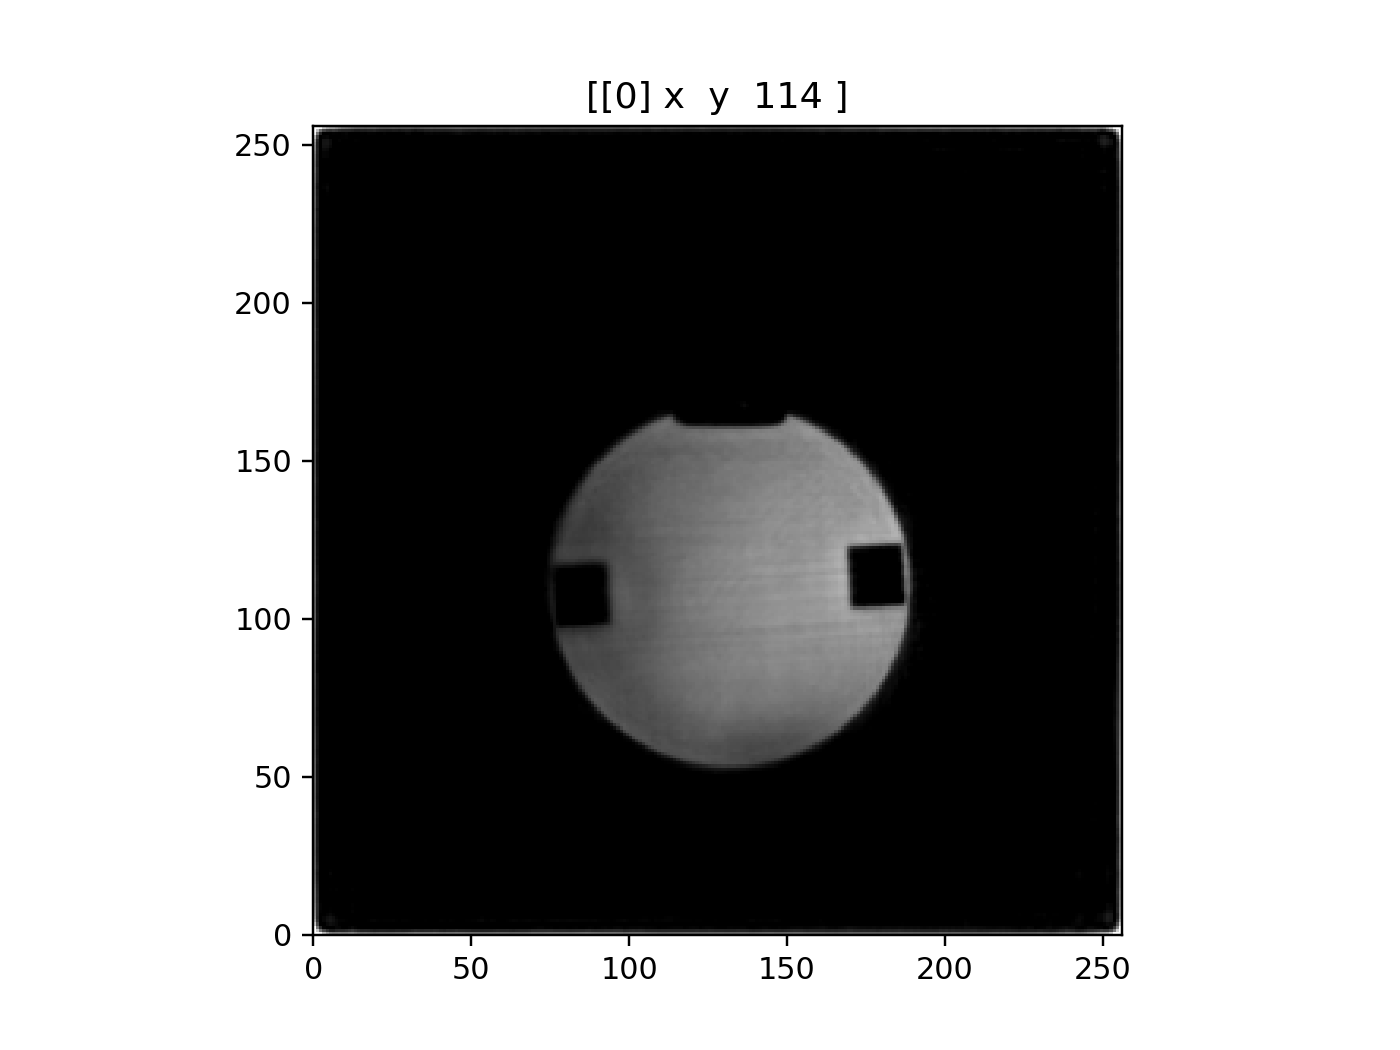

In [87]:
pl.ImagePlot(np.stack((im_optim_l2, im_random_l2, im_furthest_l2)))